# Blocking identifiaction with the Reversal index

In [ ]:
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
import sys, os
sys.path.append("/home/b/b382006/tools/Blocking/brunner/blocking/")
from BlockingDetection import Blocking
import dask

#filters and units
from scipy.ndimage import gaussian_filter
import cartopy.util as cutil

import cartopy.feature as cf
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

### many warnings problem | use size to dertimine dimensions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sys.path.append('/home/b/b382006/tools/util')
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps

### ERA5

In [ ]:
# copy only 1990 to 2019 to compare with IFS
#! ln -s /work/bm1235/b382006/era5/z500/era5_regio_prl_199* /scratch/b/b382006/obs/era5/z500
#! ln -s /work/bm1235/b382006/era5/z500/era5_regio_prl_200* /scratch/b/b382006/obs/era5/z500
#! ln -s /work/bm1235/b382006/era5/z500/era5_regio_prl_201* /scratch/b/b382006/obs/era5/z500
### temporary repository 
inpath='/scratch/b/b382006/obs/era5/z500/'
outpath='/scratch/b/b382006/obs/era5/block/ABS_500_DAV' ## ABS_Z500, ABS_Z500_DAV


In [ ]:
xr_in=xr.open_mfdataset(inpath+'era5_*')
# preprocessing
### To daily to compare with nextGEMS
daily_z = xr_in.resample(time='D').mean().compute()
#xr_in.to_netcdf(inpath+'/era5_daily.nc')
xr_in.close()
del xr_in
daily_z

In [ ]:
### years
yy0=int(daily_z['time'].time[0].dt.year)
yyn=int(daily_z['time'].time[-1].dt.year)
years=np.arange(yy0,yyn+1,1)
print(years)

In [ ]:
for year in years:
    ofile= "block_ABS-Z500_"+str(year)+".nc"

    if not os.path.exists(outpath):
        os.makedirs(outpath)
    OUTPATH=outpath+'/'+ofile

    print(OUTPATH)

    data=daily_z.sel(time=daily_z.time.dt.year.isin([year]))

#    print(data)
    ### intitate
    blk = Blocking()

    blk.import_xarray(data)

    blk.calculate_gph_from_gp() # calculate geopotential height

    blk.set_up(time_name='time', longitude_name='longitude', latitude_name='latitude')

    ### Davini
    blk.calculate_gradients(delta_degree=15)

    blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=None)

    blk.calculate_eib(min_extent_degree=15)

    blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk
    blk
    blk.save(OUTPATH, 'Blocking')

    data.close()

2025-04-02 10:39:57,802 - root - INFO - Calculated GPH from GP
2025-04-02 10:39:57,803 - root - INFO - Set time grid distance 1
2025-04-02 10:39:57,806 - root - INFO - Set longitude grid distance 1.0
2025-04-02 10:39:57,807 - root - WARNING - latitude grid not increasing. Inverse dimension!


/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1990.nc


2025-04-02 10:39:57,948 - root - INFO - Set latitude grid distance 1.0
2025-04-02 10:39:57,961 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 10:39:58,576 - root - INFO - Calculating gradients... DONE
2025-04-02 10:39:58,577 - root - INFO - Calculating IB as IB...
2025-04-02 10:39:59,014 - root - INFO - Calculating IB... DONE
2025-04-02 10:39:59,014 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 10:40:00,619 - root - INFO - Calculating extended IB... DONE
2025-04-02 10:40:00,620 - root - INFO - Calculating blocking as Blocking...
2025-04-02 10:40:00,743 - root - INFO - Calculating time step... 0%
2025-04-02 10:41:32,097 - root - INFO - Calculating time step... 10%
2025-04-02 10:42:25,654 - root - INFO - Calculating time step... 20%
2025-04-02 10:43:41,748 - root - INFO - Calculating time step... 30%
2025-04-02 10:44:51,065 - root - INFO - Calculating time step... 40%
2025-04-02 10:46:41,204 - root - INFO - Calculating time step... 5

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1991.nc


2025-04-02 10:54:45,750 - root - INFO - Calculated GPH from GP
2025-04-02 10:54:45,763 - root - INFO - Set time grid distance 1
2025-04-02 10:54:45,777 - root - INFO - Set longitude grid distance 1.0
2025-04-02 10:54:45,779 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 10:54:45,910 - root - INFO - Set latitude grid distance 1.0
2025-04-02 10:54:45,920 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 10:54:46,538 - root - INFO - Calculating gradients... DONE
2025-04-02 10:54:46,540 - root - INFO - Calculating IB as IB...
2025-04-02 10:54:46,990 - root - INFO - Calculating IB... DONE
2025-04-02 10:54:46,991 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 10:54:48,715 - root - INFO - Calculating extended IB... DONE
2025-04-02 10:54:48,716 - root - INFO - Calculating blocking as Blocking...
2025-04-02 10:54:48,845 - root - INFO - Calculating time step... 0%
2025-04-02 10:56:25,663 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1992.nc


2025-04-02 11:11:15,955 - root - INFO - Calculated GPH from GP
2025-04-02 11:11:15,992 - root - INFO - Set time grid distance 1
2025-04-02 11:11:16,033 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:11:16,035 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:11:16,169 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:11:16,179 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:11:16,791 - root - INFO - Calculating gradients... DONE
2025-04-02 11:11:16,792 - root - INFO - Calculating IB as IB...
2025-04-02 11:11:17,264 - root - INFO - Calculating IB... DONE
2025-04-02 11:11:17,264 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:11:18,960 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:11:18,961 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:11:19,089 - root - INFO - Calculating time step... 0%
2025-04-02 11:12:34,667 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1993.nc


2025-04-02 11:26:25,992 - root - INFO - Calculated GPH from GP
2025-04-02 11:26:26,002 - root - INFO - Set time grid distance 1
2025-04-02 11:26:26,020 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:26:26,021 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:26:26,155 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:26:26,167 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:26:26,788 - root - INFO - Calculating gradients... DONE
2025-04-02 11:26:26,789 - root - INFO - Calculating IB as IB...
2025-04-02 11:26:27,242 - root - INFO - Calculating IB... DONE
2025-04-02 11:26:27,243 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:26:28,930 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:26:28,931 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:26:29,061 - root - INFO - Calculating time step... 0%
2025-04-02 11:28:09,910 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1994.nc


2025-04-02 11:41:55,362 - root - INFO - Calculated GPH from GP
2025-04-02 11:41:55,366 - root - INFO - Set time grid distance 1
2025-04-02 11:41:55,370 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:41:55,370 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:41:55,505 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:41:55,518 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:41:56,119 - root - INFO - Calculating gradients... DONE
2025-04-02 11:41:56,120 - root - INFO - Calculating IB as IB...
2025-04-02 11:41:56,569 - root - INFO - Calculating IB... DONE
2025-04-02 11:41:56,570 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:41:58,284 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:41:58,285 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:41:58,413 - root - INFO - Calculating time step... 0%
2025-04-02 11:43:23,801 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1995.nc


2025-04-02 11:57:14,450 - root - INFO - Calculated GPH from GP
2025-04-02 11:57:14,457 - root - INFO - Set time grid distance 1
2025-04-02 11:57:14,484 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:57:14,484 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:57:14,630 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:57:14,642 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:57:15,300 - root - INFO - Calculating gradients... DONE
2025-04-02 11:57:15,301 - root - INFO - Calculating IB as IB...
2025-04-02 11:57:15,749 - root - INFO - Calculating IB... DONE
2025-04-02 11:57:15,750 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:57:17,466 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:57:17,467 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:57:17,596 - root - INFO - Calculating time step... 0%
2025-04-02 12:00:29,948 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1996.nc


2025-04-02 12:13:37,410 - root - INFO - Calculated GPH from GP
2025-04-02 12:13:37,414 - root - INFO - Set time grid distance 1
2025-04-02 12:13:37,418 - root - INFO - Set longitude grid distance 1.0
2025-04-02 12:13:37,418 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 12:13:37,554 - root - INFO - Set latitude grid distance 1.0
2025-04-02 12:13:37,566 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 12:13:38,171 - root - INFO - Calculating gradients... DONE
2025-04-02 12:13:38,172 - root - INFO - Calculating IB as IB...
2025-04-02 12:13:38,618 - root - INFO - Calculating IB... DONE
2025-04-02 12:13:38,618 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 12:13:40,254 - root - INFO - Calculating extended IB... DONE
2025-04-02 12:13:40,255 - root - INFO - Calculating blocking as Blocking...
2025-04-02 12:13:40,383 - root - INFO - Calculating time step... 0%
2025-04-02 12:15:30,381 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1997.nc


2025-04-02 12:29:19,588 - root - INFO - Calculated GPH from GP
2025-04-02 12:29:19,599 - root - INFO - Set time grid distance 1
2025-04-02 12:29:19,624 - root - INFO - Set longitude grid distance 1.0
2025-04-02 12:29:19,624 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 12:29:19,760 - root - INFO - Set latitude grid distance 1.0
2025-04-02 12:29:19,773 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 12:29:20,366 - root - INFO - Calculating gradients... DONE
2025-04-02 12:29:20,367 - root - INFO - Calculating IB as IB...
2025-04-02 12:29:20,812 - root - INFO - Calculating IB... DONE
2025-04-02 12:29:20,812 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 12:29:22,607 - root - INFO - Calculating extended IB... DONE
2025-04-02 12:29:22,608 - root - INFO - Calculating blocking as Blocking...
2025-04-02 12:29:22,735 - root - INFO - Calculating time step... 0%
2025-04-02 12:31:23,702 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1998.nc


2025-04-02 12:47:06,261 - root - INFO - Calculated GPH from GP
2025-04-02 12:47:06,265 - root - INFO - Set time grid distance 1
2025-04-02 12:47:06,268 - root - INFO - Set longitude grid distance 1.0
2025-04-02 12:47:06,269 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 12:47:06,405 - root - INFO - Set latitude grid distance 1.0
2025-04-02 12:47:06,418 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 12:47:07,011 - root - INFO - Calculating gradients... DONE
2025-04-02 12:47:07,011 - root - INFO - Calculating IB as IB...
2025-04-02 12:47:07,458 - root - INFO - Calculating IB... DONE
2025-04-02 12:47:07,458 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 12:47:09,283 - root - INFO - Calculating extended IB... DONE
2025-04-02 12:47:09,284 - root - INFO - Calculating blocking as Blocking...
2025-04-02 12:47:09,411 - root - INFO - Calculating time step... 0%
2025-04-02 12:48:56,614 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1999.nc


2025-04-02 13:05:38,415 - root - INFO - Calculated GPH from GP
2025-04-02 13:05:38,418 - root - INFO - Set time grid distance 1
2025-04-02 13:05:38,421 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:05:38,422 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:05:38,557 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:05:38,569 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:05:39,158 - root - INFO - Calculating gradients... DONE
2025-04-02 13:05:39,159 - root - INFO - Calculating IB as IB...
2025-04-02 13:05:39,596 - root - INFO - Calculating IB... DONE
2025-04-02 13:05:39,597 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:05:41,286 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:05:41,286 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:05:41,414 - root - INFO - Calculating time step... 0%
2025-04-02 13:07:35,153 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2000.nc


2025-04-02 13:22:16,501 - root - INFO - Calculated GPH from GP
2025-04-02 13:22:16,504 - root - INFO - Set time grid distance 1
2025-04-02 13:22:16,507 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:22:16,508 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:22:16,651 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:22:16,663 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:22:17,515 - root - INFO - Calculating gradients... DONE
2025-04-02 13:22:17,558 - root - INFO - Calculating IB as IB...
2025-04-02 13:22:18,062 - root - INFO - Calculating IB... DONE
2025-04-02 13:22:18,063 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:22:19,729 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:22:19,730 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:22:19,861 - root - INFO - Calculating time step... 0%
2025-04-02 13:24:02,086 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2001.nc


2025-04-02 13:39:05,660 - root - INFO - Calculated GPH from GP
2025-04-02 13:39:05,662 - root - INFO - Set time grid distance 1
2025-04-02 13:39:05,665 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:39:05,666 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:39:05,823 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:39:05,836 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:39:06,447 - root - INFO - Calculating gradients... DONE
2025-04-02 13:39:06,448 - root - INFO - Calculating IB as IB...
2025-04-02 13:39:06,896 - root - INFO - Calculating IB... DONE
2025-04-02 13:39:06,896 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:39:08,562 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:39:08,563 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:39:08,687 - root - INFO - Calculating time step... 0%
2025-04-02 13:41:05,576 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2002.nc


2025-04-02 13:55:48,751 - root - INFO - Calculated GPH from GP
2025-04-02 13:55:48,756 - root - INFO - Set time grid distance 1
2025-04-02 13:55:48,759 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:55:48,760 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:55:48,898 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:55:48,911 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:55:49,539 - root - INFO - Calculating gradients... DONE
2025-04-02 13:55:49,539 - root - INFO - Calculating IB as IB...
2025-04-02 13:55:49,994 - root - INFO - Calculating IB... DONE
2025-04-02 13:55:49,995 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:55:51,960 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:55:51,974 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:55:52,100 - root - INFO - Calculating time step... 0%
2025-04-02 13:57:31,346 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2003.nc


2025-04-02 14:13:21,383 - root - INFO - Calculated GPH from GP
2025-04-02 14:13:21,386 - root - INFO - Set time grid distance 1
2025-04-02 14:13:21,389 - root - INFO - Set longitude grid distance 1.0
2025-04-02 14:13:21,390 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 14:13:21,536 - root - INFO - Set latitude grid distance 1.0
2025-04-02 14:13:21,548 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 14:13:22,200 - root - INFO - Calculating gradients... DONE
2025-04-02 14:13:22,201 - root - INFO - Calculating IB as IB...
2025-04-02 14:13:22,658 - root - INFO - Calculating IB... DONE
2025-04-02 14:13:22,658 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 14:13:24,338 - root - INFO - Calculating extended IB... DONE
2025-04-02 14:13:24,338 - root - INFO - Calculating blocking as Blocking...
2025-04-02 14:13:24,464 - root - INFO - Calculating time step... 0%
2025-04-02 14:15:26,734 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2004.nc


2025-04-02 14:30:43,437 - root - INFO - Calculated GPH from GP
2025-04-02 14:30:43,455 - root - INFO - Set time grid distance 1
2025-04-02 14:30:43,490 - root - INFO - Set longitude grid distance 1.0
2025-04-02 14:30:43,494 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 14:30:43,646 - root - INFO - Set latitude grid distance 1.0
2025-04-02 14:30:43,656 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 14:30:44,254 - root - INFO - Calculating gradients... DONE
2025-04-02 14:30:44,254 - root - INFO - Calculating IB as IB...
2025-04-02 14:30:44,710 - root - INFO - Calculating IB... DONE
2025-04-02 14:30:44,710 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 14:30:46,305 - root - INFO - Calculating extended IB... DONE
2025-04-02 14:30:46,305 - root - INFO - Calculating blocking as Blocking...
2025-04-02 14:30:46,433 - root - INFO - Calculating time step... 0%
2025-04-02 14:32:07,218 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2005.nc


2025-04-02 14:46:49,172 - root - INFO - Calculated GPH from GP
2025-04-02 14:46:49,175 - root - INFO - Set time grid distance 1
2025-04-02 14:46:49,180 - root - INFO - Set longitude grid distance 1.0
2025-04-02 14:46:49,181 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 14:46:49,312 - root - INFO - Set latitude grid distance 1.0
2025-04-02 14:46:49,322 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 14:46:49,907 - root - INFO - Calculating gradients... DONE
2025-04-02 14:46:49,908 - root - INFO - Calculating IB as IB...
2025-04-02 14:46:50,344 - root - INFO - Calculating IB... DONE
2025-04-02 14:46:50,345 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 14:46:51,997 - root - INFO - Calculating extended IB... DONE
2025-04-02 14:46:51,997 - root - INFO - Calculating blocking as Blocking...
2025-04-02 14:46:52,124 - root - INFO - Calculating time step... 0%
2025-04-02 14:48:44,386 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2006.nc


2025-04-02 15:04:13,702 - root - INFO - Calculated GPH from GP
2025-04-02 15:04:13,719 - root - INFO - Set time grid distance 1
2025-04-02 15:04:13,737 - root - INFO - Set longitude grid distance 1.0
2025-04-02 15:04:13,740 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 15:04:13,874 - root - INFO - Set latitude grid distance 1.0
2025-04-02 15:04:13,885 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 15:04:14,477 - root - INFO - Calculating gradients... DONE
2025-04-02 15:04:14,478 - root - INFO - Calculating IB as IB...
2025-04-02 15:04:14,985 - root - INFO - Calculating IB... DONE
2025-04-02 15:04:14,986 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 15:04:16,588 - root - INFO - Calculating extended IB... DONE
2025-04-02 15:04:16,589 - root - INFO - Calculating blocking as Blocking...
2025-04-02 15:04:16,766 - root - INFO - Calculating time step... 0%
2025-04-02 15:06:21,702 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2007.nc


2025-04-02 15:20:57,976 - root - INFO - Calculated GPH from GP
2025-04-02 15:20:57,984 - root - INFO - Set time grid distance 1
2025-04-02 15:20:57,997 - root - INFO - Set longitude grid distance 1.0
2025-04-02 15:20:57,998 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 15:20:58,135 - root - INFO - Set latitude grid distance 1.0
2025-04-02 15:20:58,148 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 15:20:58,794 - root - INFO - Calculating gradients... DONE
2025-04-02 15:20:59,068 - root - INFO - Calculating IB as IB...
2025-04-02 15:21:00,177 - root - INFO - Calculating IB... DONE
2025-04-02 15:21:00,185 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 15:21:01,898 - root - INFO - Calculating extended IB... DONE
2025-04-02 15:21:01,899 - root - INFO - Calculating blocking as Blocking...
2025-04-02 15:21:02,039 - root - INFO - Calculating time step... 0%
2025-04-02 15:22:44,749 - root - INFO - Calculatin

In [ ]:
### full data

In [ ]:

### intitate
blk = Blocking()

blk.import_xarray(xr_in)

###era5
blk.calculate_gph_from_gp() # calculate geopotential height

blk.set_up(time_name='time', longitude_name='longitude', latitude_name='latitude')

'''
### Brunner
blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

# 
blk.calculate_eib(min_extent_degree=15)
# 
blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

OUTPATH=outpath+'ABS_Z500/IB.nc'
OUTPATH2=outpath+'ABS_Z500/ExtendB.nc'
OUTPATH3=outpath+'ABS_Z500/BLOCKS'+subfix+'.nc'

####
'''

### Davini
blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=None)

blk.calculate_eib(min_extent_degree=15)

blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

OUTPATH=outpath+'/IB.nc'
OUTPATH2=outpath+'/ExtendB.nc'
OUTPATH3=outpath+'/BLOCKS'+subfix+'.nc'

###

### years
yy0=int(xr_in['time'].time[0].dt.year)
yyn=int(xr_in['time'].time[-1].dt.year)

subfix='-ERA5-'+str(yy0)+'-'+str(yyn)+''

print(yy0,yyn,OUTPATH3)

# save to disk 
blk.save(OUTPATH, 'IB')
blk.save(OUTPATH2, 'ExtendedIB')
blk.save(OUTPATH3, 'Blocking')


2025-04-02 10:15:56,946 - root - INFO - Set time grid distance 1
2025-04-02 10:15:56,949 - root - INFO - Set longitude grid distance 1.0
2025-04-02 10:15:56,950 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 10:16:04,755 - root - INFO - Set latitude grid distance 1.0
2025-04-02 10:16:05,189 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 10:16:28,600 - root - INFO - Calculating gradients... DONE
2025-04-02 10:16:28,699 - root - INFO - Calculating IB as IB...


### IFS simulations

In [2]:
### blocking method based on the original Code of Lukas Brunner
## nextGEMS
#id_exp='IFS_9-FESOM_5-production-hist' #IFS_9-FESOM_5-production, IFS_9-FESOM_5-production-hist
#inpath='/work/bm1235/b382006/nextgems/prefinal/'+id_exp+'/' 
#outpath='/scratch/b/b382006/nextgems/prefinal/'+id_exp+'/' 
#xr_in=xr.open_mfdataset(inpath+'/z/6H/z500_'+id_exp+'_*')

## IFS AMIP
id_exp='ifs-fesom2-sr' #ifs-fesom2-sr, 'ifs-amip-tco1279'
inpath='/scratch/b/b382006/EERIE/cycle1/'+id_exp+'/'
outpath=inpath
resolution='3D_6hourly' #6H, 3D_6hourly 
xr_in=xr.open_mfdataset(inpath+'/z500/'+resolution+'/z500_ifs_c1_*')
xr_in = xr_in.sel(time=slice('1985','2014')) ## only 30 years

In [3]:
#xr_in['z'][0,...].plot()

In [4]:
daily_z = xr_in.resample(time='D').mean()#.compute()
daily_z

xr_in.close()  # here we properly close the dataset. It will still be in memory though.
del xr_in

In [5]:
### some pre-processing

In [6]:
### take care of time format --> change to yyyy mm dd - daily icon/ifs
#xr_in['time']=xr_in.indexes['time'].normalize()

###=== rename zfull
#xr_in=xr_in.rename({'z':'GeopotentialHeight'})

###for era5
#dxr_in=xr_in.drop_dims('bnds')
#dxr_in

### Take geopotential
###icon
#in_z_500=xr_in.GeopotentialHeight.sel(plev=50000.0)
#daily_z=in_z_500.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean
#dataset_z=xr.DataArray.to_dataset(daily_z)
#dataset_z.GeopotentialHeight

###==era5
#dataset_z=xr_in.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean

#dataset_z.time.attrs['standard_name'] = 'time'
#dataset_z.time.attrs['axis'] = 'T'
#dataset_z.time

#xr_in.time.attrs['standard_name'] = 'time'
#xr_in.time.attrs['axis'] = 'T'
#xr_in.time

## DO we need to resample???
###xr_in=xr_in.resample(time='6H').mean(dim='time',keep_attrs=True) #6 hourly mean
#daily_z=xr_in.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean
#daily_z

### remove extra dimension level
#daily_z =xr_in.isel(level=0, drop=True)


In [7]:
#OUTPATH = dataset_z.replace(
#    'geopotential', 'blocking').replace('.nc', '_bf_3D.nc')
OUTPATH=outpath+'block/ABS_Z500/IB.nc'
OUTPATH2=outpath+'block/ABS_Z500/ExtendB.nc'
OUTPATH3=outpath+'block/ABS_Z500/blocking.nc'
yy0=int(daily_z['time'].time[0].dt.year)
yyn=int(daily_z['time'].time[-1].dt.year)
print(yy0,yyn,OUTPATH)

1985 2014 /scratch/b/b382006/EERIE/cycle1/ifs-fesom2-sr/block/ABS_Z500/IB.nc


In [8]:
### intitate
blk = Blocking()
#blk.import_xarray(dataset_z)
blk.import_xarray(daily_z)
#blk.ds

## pre-processing
##blk.get_time_subset(months='DJF')
##blk.calculate_daily_mean()

###era5
blk.calculate_gph_from_gp() # calculate geopotential height

#blk.ds.time
#blk.ds.GeopotentialHeight
#blk.ds.GeopotentialHeight

2025-04-23 16:23:39,789 - root - INFO - Calculated GPH from GP


In [9]:
###

In [ ]:
blk.set_up(time_name='time', longitude_name='lon', latitude_name='lat')

blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

# 
blk.calculate_eib(min_extent_degree=15)
# 
blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk 
blk.save(OUTPATH, 'IB')
blk.save(OUTPATH2, 'ExtendedIB')
blk.save(OUTPATH3, 'Blocking')

2025-04-23 16:23:41,534 - root - INFO - Set time grid distance 1
2025-04-23 16:23:41,534 - root - INFO - Set lon grid distance 1
2025-04-23 16:23:41,535 - root - INFO - Set lat grid distance 1
2025-04-23 16:23:41,535 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-23 16:23:46,875 - root - INFO - Calculating gradients... DONE
2025-04-23 16:23:46,891 - root - INFO - Calculating IB as IB...
2025-04-23 16:27:43,682 - root - INFO - Calculating IB... DONE
2025-04-23 16:27:43,814 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-23 16:28:15,954 - root - INFO - Calculating extended IB... DONE
2025-04-23 16:28:16,096 - root - INFO - Calculating blocking as Blocking...
2025-04-23 16:28:19,336 - root - INFO - Calculating time step... 0%
2025-04-23 16:36:13,956 - root - INFO - Calculating time step... 10%
2025-04-23 16:44:03,835 - root - INFO - Calculating time step... 20%
2025-04-23 16:52:07,417 - root - INFO - Calculating time step... 30%
2025-04-23 17

In [ ]:
###

In [ ]:
###

### ICON simulations

In [14]:
### icon DestinE pre-processing
'''
#########=== START Process for DestinE data
inpath='/scratch/b/b382006/icon-climate-dt/'
id_exp=''
tres='netcdf'

daily_z=xr.open_mfdataset(inpath+id_exp+'/zg/'+tres+'/*nc')

#########=== START Process for DestinE data
###==rename
daily_z=daily_z.rename({'longitude':'lon',
                  'latitude':'lat',
                  'forecast_reference_time':'time',
                       })

daily_z['z']=daily_z['z'].assign_attrs(units='m**2 s**-2')

### remove last months due to high missing numbers
daily_z=daily_z.sel(time=slice('1993-01','2012-09'))

### Daily mean
daily_z=daily_z.resample(time='D').mean().compute()

daily_z['z']=daily_z['z'].assign_attrs(_earthkit='none')
daily_z['z'].to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')
'''
########====

"\n#########=== START Process for DestinE data\ninpath='/scratch/b/b382006/icon-climate-dt/'\nid_exp=''\ntres='netcdf'\n\ndaily_z=xr.open_mfdataset(inpath+id_exp+'/zg/'+tres+'/*nc')\n\n#########=== START Process for DestinE data\n###==rename\ndaily_z=daily_z.rename({'longitude':'lon',\n                  'latitude':'lat',\n                  'forecast_reference_time':'time',\n                       })\n\ndaily_z['z']=daily_z['z'].assign_attrs(units='m**2 s**-2')\n\n### remove last months due to high missing numbers\ndaily_z=daily_z.sel(time=slice('1993-01','2012-09'))\n\n### Daily mean\ndaily_z=daily_z.resample(time='D').mean().compute()\n\ndaily_z['z']=daily_z['z'].assign_attrs(_earthkit='none')\ndaily_z['z'].to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')\n"

In [15]:
#daily_z#.to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')
#daily_z['z']=daily_z['z'].assign_attrs(_earthkit='none')
#daily_z['z'].to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')

In [22]:
### icon production
inpath='/work/bm1235/b382006/nextgems/prefinal/'
outpath='/scratch/b/b382006/nextgems/prefinal/'
id_exp='ngc4008'
tres='daily'
daily_z=xr.open_mfdataset(inpath+id_exp+'/zg/'+tres+'/zg50000_icon_prefinal*')
#daily_z

### icon DestinE
#inpath='/scratch/b/b382006/icon-climate-dt/'
#outpath=inpath
#id_exp=''
#tres='daily'
#daily_z=xr.open_mfdataset(inpath+id_exp+'/zg/'+tres+'/icon-climate-dt_zg_daily.nc')



# Now `GeopotentialHeight` replaces `zg` in production ngc4008 runs
daily_z = daily_z.rename({'zg': 'GeopotentialHeight'})
#print(daily_z)

OUTPATH=outpath+id_exp+'/'+'block/ABS_Z500/IB.nc'
OUTPATH2=outpath+id_exp+'/'+'block/ABS_Z500/ExtendB.nc'
OUTPATH3=outpath+id_exp+'/'+'block/ABS_Z500/blocking.nc'

yy0=int(daily_z['time'].time[0].dt.year)
yyn=int(daily_z['time'].time[-1].dt.year)
print(yy0,yyn,OUTPATH3)

### intitate
blk = Blocking()
blk.import_xarray(daily_z)


### DestinE
#blk.calculate_gph_from_gp() # calculate geopotential height

### many warnings problem | use size to dertimine dimensions
warnings.filterwarnings("ignore", category=FutureWarning)

blk.set_up(time_name='time', longitude_name='lon', latitude_name='lat')

blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

# 
blk.calculate_eib(min_extent_degree=15)
# 
blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk 
blk.save(OUTPATH, 'IB')
blk.save(OUTPATH2, 'ExtendedIB')
blk.save(OUTPATH3, 'Blocking')

2025-04-14 20:19:55,692 - root - INFO - Set time grid distance 1
2025-04-14 20:19:55,693 - root - INFO - Set lon grid distance 1
2025-04-14 20:19:55,693 - root - WARNING - lat grid not increasing. Inverse dimension!
2025-04-14 20:19:55,715 - root - INFO - Set lat grid distance 1
2025-04-14 20:19:55,717 - root - INFO - Calculate gradients as GeopotentialHeightGradient...


2020 2050 /work/bm1235/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/blocking.nc


2025-04-14 20:19:56,780 - root - INFO - Calculating gradients... DONE
2025-04-14 20:19:56,802 - root - INFO - Calculating IB as IB...
2025-04-14 20:20:24,790 - root - INFO - Calculating IB... DONE
2025-04-14 20:20:24,791 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-14 20:20:55,434 - root - INFO - Calculating extended IB... DONE
2025-04-14 20:20:55,435 - root - INFO - Calculating blocking as Blocking...
2025-04-14 20:20:59,214 - root - INFO - Calculating time step... 0%
2025-04-14 20:32:12,915 - root - INFO - Calculating time step... 10%
2025-04-14 20:42:35,780 - root - INFO - Calculating time step... 20%
2025-04-14 20:52:50,963 - root - INFO - Calculating time step... 30%
2025-04-14 21:02:05,922 - root - INFO - Calculating time step... 40%
2025-04-14 21:11:39,850 - root - INFO - Calculating time step... 50%
2025-04-14 21:21:38,206 - root - INFO - Calculating time step... 60%
2025-04-14 21:31:21,051 - root - INFO - Calculating time step... 70%
2025-04-14 21:41:20,774

PermissionError: [Errno 13] Permission denied: '/work/bm1235/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/IB.nc'

In [25]:
###

### Open saved data 

In [13]:
#inpath='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/'
block = xr.open_dataset(OUTPATH)
block2 = xr.open_dataset(OUTPATH2)
block3 = xr.open_dataset(OUTPATH3)

ntime=len(block.time)
ntime

10939

In [14]:
### accumulate 
acc=block.IB.sum(dim='time')
acc2=block2.ExtendedIB.sum(dim='time')
acc3=block3.Blocking.sum(dim='time')
acc = acc/ntime
acc *= 100

acc2 = acc2/ntime
acc2 *= 100

acc3 = acc3/ntime
acc3 *= 100

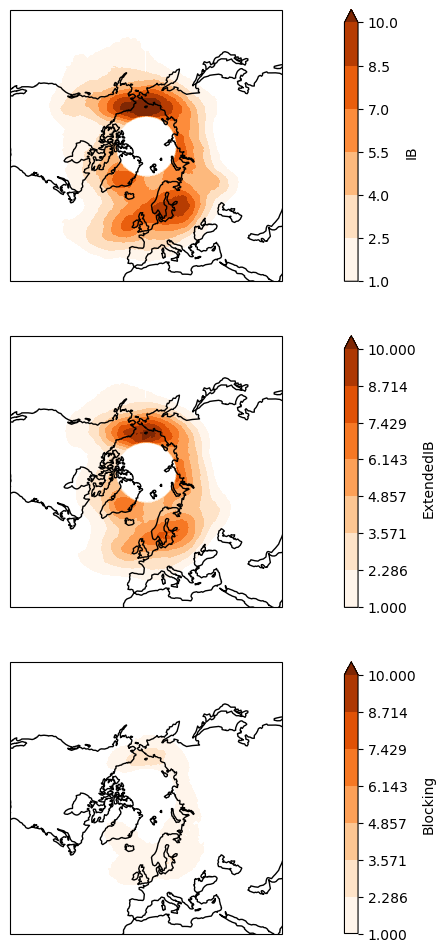

In [15]:

###=== plotting
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#std_djf.plot(ax=ax1,levels=np.linspace(200,800,11), cmap='YlOrRd', extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True)
#dstd_djf[0,:,:].
acc.plot.contourf(ax=ax1,levels = np.linspace(1,10,7),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

acc2.plot.contourf(ax=ax2,levels = np.linspace(1,10,8),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

acc3.plot.contourf(ax=ax3,levels = np.linspace(1,10,8),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

#acc.plot.contour(colors='grey', linewidths=0.8, levels = np.linspace(2,16,8), transform=ccrs.PlateCarree())





## Compute for whole period year by year

In [4]:
### Method 1

In [16]:
'''
###cmip6 ["MRI-ESM2-0","ACCESS-CM2","EC-Earth3","CESM2-WACCM","MIROC6","MPI-ESM1-2-HR","MPI-ESM1-2-LR","CESM2"]

exper='historical' #'ssp585'
inpath="/scratch/b/b382006/cmip6/"+exper+"/"
outpath = "/scratch/b/b382006/cmip6/"+exper+"/"
model="ACCESS-CM2"
member_id="r1i1p1f1"

#infile=inpath+model+"/"+member_id+"/daily/50000/cmip6_zg_*"
#xr_in=xr.open_mfdataset(infile)

xr_in=xr.open_mfdataset('/work/bm1235/b382006/cmip6/ACCESS-CM2/r1i1p1f1/daily/201?/Z*')


### Sel one pressure level of 500 hPa
xr_in=xr_in.sel(plev=50000., drop=True)

###==output
###nextgems
#dir_res='/scratch/b/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/'
##dir_res='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/'

###cmip6 
dir_res=outpath+model+"/"+member_id+"/block/ABS_500"

print(dir_res)

y0=1979 #2061 #1979, 2025, 2061
yn=2015 #2101 #2015, 2050, 2101
years=np.arange(y0,yn,1)


for year in years:
    ofile= "block_ABS-Z500_"+str(year)+".nc"

    if not os.path.exists(dir_res):
        os.makedirs(dir_res)

    OUTPATH=dir_res+'/'+ofile
    OUTPATH2=dir_res+'/ExtendB_'+str(year)+'.nc'
    OUTPATH3=dir_res+'/IB_'+str(year)+'.nc'

    print(OUTPATH)

    ### IFS Compute yearly
#    data=daily_z.sel(time=daily_z.time.dt.year.isin([year]))
    ### ICON Compute yearly
    data=xr_in.sel(time=xr_in.time.dt.year.isin([year]))

###=== intitate
    blk = Blocking()

    blk.import_xarray(data)

    ### not for ICON
    blk.calculate_gph_from_gp(gp_name='Z') # calculate geopotential height

    blk.set_up(time_name='time',longitude_name='lon', latitude_name='lat')

    blk.calculate_gradients(delta_degree=15)

    blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

#
    blk.calculate_eib(min_extent_degree=15)

#
    blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk
#    blk.save(OUTPATH, 'Blocking')
    blk.save(OUTPATH2, 'ExtendedIB')
    blk.save(OUTPATH3, 'IB')

    data.close()
'''

'\n###cmip6 ["MRI-ESM2-0","ACCESS-CM2","EC-Earth3","CESM2-WACCM","MIROC6","MPI-ESM1-2-HR","MPI-ESM1-2-LR","CESM2"]\n\nexper=\'historical\' #\'ssp585\'\ninpath="/scratch/b/b382006/cmip6/"+exper+"/"\noutpath = "/scratch/b/b382006/cmip6/"+exper+"/"\nmodel="ACCESS-CM2"\nmember_id="r1i1p1f1"\n\n#infile=inpath+model+"/"+member_id+"/daily/50000/cmip6_zg_*"\n#xr_in=xr.open_mfdataset(infile)\n\nxr_in=xr.open_mfdataset(\'/work/bm1235/b382006/cmip6/ACCESS-CM2/r1i1p1f1/daily/201?/Z*\')\n\n\n### Sel one pressure level of 500 hPa\nxr_in=xr_in.sel(plev=50000., drop=True)\n\n###==output\n###nextgems\n#dir_res=\'/scratch/b/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/\'\n##dir_res=\'/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/\'\n\n###cmip6 \ndir_res=outpath+model+"/"+member_id+"/block/ABS_500"\n\nprint(dir_res)\n\ny0=1979 #2061 #1979, 2025, 2061\nyn=2015 #2101 #2015, 2050, 2101\nyears=np.arange(y0,yn,1)\n\n\nfor year in years:\n    ofile= "block_ABS-Z500_"+str(year

In [11]:
###

In [4]:
### Method 2

### experiment
exper='historical' #'ssp585'
##infile=inpath+model+"/"+member_id+"/daily/50000/cmip6_zg_*"
inpath='/work/bm1235/b382006/cmip6/'
outpath = "/scratch/b/b382006/cmip6/"+exper+"/"
model="MRI-ESM2-0"
member_id="r1i1p1f1"

    
y0=1969 #2061 #1979, 2025, 2061
yn=1979 #2101 #2015, 2050, 2101
years=np.arange(y0,yn,1)
#print(xr_in)

In [5]:
###

In [6]:
### versus ERA5### compute blocking yearly to save memory:
from pathlib import Path

dir_res = Path(outpath) / model / member_id / "block" / "ABS_500"
dir_res.mkdir(parents=True, exist_ok=True)

for year in years:
    
    print(f"Processing {year} {dir_res}")
    
    out_main = dir_res / f"block_ABS-Z500_{year}.nc"
    out_ext = dir_res / f"ExtendB_{year}.nc"
    out_ib = dir_res / f"IB_{year}.nc"

    if out_main.exists() and out_ext.exists() and out_ib.exists():
        print(f"Skipping {year}, files exist.")
        continue

    # Load only this year's files
    xr_in = xr.open_mfdataset(
        f"{inpath}/{model}/{member_id}/daily/{year}/Z*",
        combine='by_coords'
    ).sel(plev=50000., drop=True)
    

    ### IFS Compute yearly
#    data=daily_z.sel(time=daily_z.time.dt.year.isin([year]))
    ### ICON Compute yearly
#    data=xr_in.sel(time=xr_in.time.dt.year.isin([year]))
#    data = xr_in.sel(time=str(year))


###=== intitate
    blk = Blocking()

    blk.import_xarray(xr_in)

    ### not for ICON
    blk.calculate_gph_from_gp(gp_name='Z') # calculate geopotential height

    blk.set_up(time_name='time',longitude_name='lon', latitude_name='lat')

    blk.calculate_gradients(delta_degree=15)

    blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

#
    blk.calculate_eib(min_extent_degree=15)

#
    blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk
    blk.save(out_main, 'Blocking')
    blk.save(out_ext, 'ExtendedIB')
    blk.save(out_ib, 'IB')

    xr_in.close()
    


Processing 1969 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 22:49:47,807 - root - INFO - Calculated GPH from GP
2025-04-16 22:49:47,809 - root - INFO - Set time grid distance 1
2025-04-16 22:49:47,810 - root - INFO - Set lon grid distance 1
2025-04-16 22:49:47,814 - root - INFO - Set lat grid distance 1.0
2025-04-16 22:49:47,814 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 22:49:49,655 - root - INFO - Calculating gradients... DONE
2025-04-16 22:49:49,657 - root - INFO - Calculating IB as IB...
2025-04-16 22:50:10,362 - root - INFO - Calculating IB... DONE
2025-04-16 22:50:10,363 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 22:50:11,095 - root - INFO - Calculating extended IB... DONE
2025-04-16 22:50:11,097 - root - INFO - Calculating blocking as Blocking...
2025-04-16 22:50:11,214 - root - INFO - Calculating time step... 0%
2025-04-16 22:50:24,461 - root - INFO - Calculating time step... 10%
2025-04-16 22:50:47,957 - root - INFO - Calculating time step... 20%
2025-04-16 22:51:

Processing 1970 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 22:54:24,486 - root - INFO - Calculated GPH from GP
2025-04-16 22:54:24,488 - root - INFO - Set time grid distance 1
2025-04-16 22:54:24,488 - root - INFO - Set lon grid distance 1
2025-04-16 22:54:24,488 - root - INFO - Set lat grid distance 1.0
2025-04-16 22:54:24,489 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 22:54:24,562 - root - INFO - Calculating gradients... DONE
2025-04-16 22:54:24,563 - root - INFO - Calculating IB as IB...
2025-04-16 22:54:54,469 - root - INFO - Calculating IB... DONE
2025-04-16 22:54:54,470 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 22:54:55,203 - root - INFO - Calculating extended IB... DONE
2025-04-16 22:54:55,204 - root - INFO - Calculating blocking as Blocking...
2025-04-16 22:54:55,323 - root - INFO - Calculating time step... 0%
2025-04-16 22:55:21,062 - root - INFO - Calculating time step... 10%
2025-04-16 22:55:39,494 - root - INFO - Calculating time step... 20%
2025-04-16 22:56:

Processing 1971 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 22:58:44,042 - root - INFO - Calculated GPH from GP
2025-04-16 22:58:44,061 - root - INFO - Set time grid distance 1
2025-04-16 22:58:44,062 - root - INFO - Set lon grid distance 1
2025-04-16 22:58:44,063 - root - INFO - Set lat grid distance 1.0
2025-04-16 22:58:44,063 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 22:58:44,144 - root - INFO - Calculating gradients... DONE
2025-04-16 22:58:44,144 - root - INFO - Calculating IB as IB...
2025-04-16 22:59:10,254 - root - INFO - Calculating IB... DONE
2025-04-16 22:59:10,305 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 22:59:11,100 - root - INFO - Calculating extended IB... DONE
2025-04-16 22:59:11,101 - root - INFO - Calculating blocking as Blocking...
2025-04-16 22:59:11,251 - root - INFO - Calculating time step... 0%
2025-04-16 22:59:30,176 - root - INFO - Calculating time step... 10%
2025-04-16 22:59:47,843 - root - INFO - Calculating time step... 20%
2025-04-16 23:00:

Processing 1972 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 23:03:56,169 - root - INFO - Calculated GPH from GP
2025-04-16 23:03:56,183 - root - INFO - Set time grid distance 1
2025-04-16 23:03:56,183 - root - INFO - Set lon grid distance 1
2025-04-16 23:03:56,185 - root - INFO - Set lat grid distance 1.0
2025-04-16 23:03:56,186 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 23:03:56,283 - root - INFO - Calculating gradients... DONE
2025-04-16 23:03:56,284 - root - INFO - Calculating IB as IB...
2025-04-16 23:04:18,442 - root - INFO - Calculating IB... DONE
2025-04-16 23:04:18,443 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 23:04:19,187 - root - INFO - Calculating extended IB... DONE
2025-04-16 23:04:19,188 - root - INFO - Calculating blocking as Blocking...
2025-04-16 23:04:19,301 - root - INFO - Calculating time step... 0%
2025-04-16 23:04:40,240 - root - INFO - Calculating time step... 10%
2025-04-16 23:05:02,808 - root - INFO - Calculating time step... 20%
2025-04-16 23:05:

Processing 1973 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 23:08:12,933 - root - INFO - Calculated GPH from GP
2025-04-16 23:08:12,934 - root - INFO - Set time grid distance 1
2025-04-16 23:08:12,935 - root - INFO - Set lon grid distance 1
2025-04-16 23:08:12,935 - root - INFO - Set lat grid distance 1.0
2025-04-16 23:08:12,936 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 23:08:13,159 - root - INFO - Calculating gradients... DONE
2025-04-16 23:08:13,160 - root - INFO - Calculating IB as IB...
2025-04-16 23:08:41,537 - root - INFO - Calculating IB... DONE
2025-04-16 23:08:41,538 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 23:08:42,369 - root - INFO - Calculating extended IB... DONE
2025-04-16 23:08:42,370 - root - INFO - Calculating blocking as Blocking...
2025-04-16 23:08:42,524 - root - INFO - Calculating time step... 0%
2025-04-16 23:09:02,229 - root - INFO - Calculating time step... 10%
2025-04-16 23:09:25,502 - root - INFO - Calculating time step... 20%
2025-04-16 23:10:

Processing 1974 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 23:13:15,266 - root - INFO - Calculated GPH from GP
2025-04-16 23:13:15,276 - root - INFO - Set time grid distance 1
2025-04-16 23:13:15,277 - root - INFO - Set lon grid distance 1
2025-04-16 23:13:15,277 - root - INFO - Set lat grid distance 1.0
2025-04-16 23:13:15,278 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 23:13:15,354 - root - INFO - Calculating gradients... DONE
2025-04-16 23:13:15,355 - root - INFO - Calculating IB as IB...
2025-04-16 23:13:37,940 - root - INFO - Calculating IB... DONE
2025-04-16 23:13:37,950 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 23:13:38,731 - root - INFO - Calculating extended IB... DONE
2025-04-16 23:13:38,731 - root - INFO - Calculating blocking as Blocking...
2025-04-16 23:13:38,858 - root - INFO - Calculating time step... 0%
2025-04-16 23:14:01,681 - root - INFO - Calculating time step... 10%
2025-04-16 23:14:23,757 - root - INFO - Calculating time step... 20%
2025-04-16 23:14:

Processing 1975 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 23:18:19,527 - root - INFO - Calculated GPH from GP
2025-04-16 23:18:19,558 - root - INFO - Set time grid distance 1
2025-04-16 23:18:19,559 - root - INFO - Set lon grid distance 1
2025-04-16 23:18:19,564 - root - INFO - Set lat grid distance 1.0
2025-04-16 23:18:19,564 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 23:18:19,696 - root - INFO - Calculating gradients... DONE
2025-04-16 23:18:19,697 - root - INFO - Calculating IB as IB...
2025-04-16 23:18:43,064 - root - INFO - Calculating IB... DONE
2025-04-16 23:18:43,066 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 23:18:43,871 - root - INFO - Calculating extended IB... DONE
2025-04-16 23:18:43,872 - root - INFO - Calculating blocking as Blocking...
2025-04-16 23:18:44,025 - root - INFO - Calculating time step... 0%
2025-04-16 23:18:57,974 - root - INFO - Calculating time step... 10%
2025-04-16 23:19:17,678 - root - INFO - Calculating time step... 20%
2025-04-16 23:19:

Processing 1976 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 23:22:51,953 - root - INFO - Calculated GPH from GP
2025-04-16 23:22:51,983 - root - INFO - Set time grid distance 1
2025-04-16 23:22:51,983 - root - INFO - Set lon grid distance 1
2025-04-16 23:22:51,996 - root - INFO - Set lat grid distance 1.0
2025-04-16 23:22:51,997 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 23:22:52,281 - root - INFO - Calculating gradients... DONE
2025-04-16 23:22:52,282 - root - INFO - Calculating IB as IB...
2025-04-16 23:23:17,413 - root - INFO - Calculating IB... DONE
2025-04-16 23:23:17,414 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 23:23:18,196 - root - INFO - Calculating extended IB... DONE
2025-04-16 23:23:18,197 - root - INFO - Calculating blocking as Blocking...
2025-04-16 23:23:18,326 - root - INFO - Calculating time step... 0%
2025-04-16 23:23:43,862 - root - INFO - Calculating time step... 10%
2025-04-16 23:24:03,127 - root - INFO - Calculating time step... 20%
2025-04-16 23:24:

Processing 1977 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 23:27:42,552 - root - INFO - Calculated GPH from GP
2025-04-16 23:27:42,562 - root - INFO - Set time grid distance 1
2025-04-16 23:27:42,562 - root - INFO - Set lon grid distance 1
2025-04-16 23:27:42,567 - root - INFO - Set lat grid distance 1.0
2025-04-16 23:27:42,568 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 23:27:42,684 - root - INFO - Calculating gradients... DONE
2025-04-16 23:27:42,685 - root - INFO - Calculating IB as IB...
2025-04-16 23:28:00,969 - root - INFO - Calculating IB... DONE
2025-04-16 23:28:00,970 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 23:28:01,701 - root - INFO - Calculating extended IB... DONE
2025-04-16 23:28:01,702 - root - INFO - Calculating blocking as Blocking...
2025-04-16 23:28:01,827 - root - INFO - Calculating time step... 0%
2025-04-16 23:28:17,060 - root - INFO - Calculating time step... 10%
2025-04-16 23:28:24,222 - root - INFO - Calculating time step... 20%
2025-04-16 23:28:

Processing 1978 /scratch/b/b382006/cmip6/historical/MRI-ESM2-0/r1i1p1f1/block/ABS_500


2025-04-16 23:31:26,075 - root - INFO - Calculated GPH from GP
2025-04-16 23:31:26,076 - root - INFO - Set time grid distance 1
2025-04-16 23:31:26,077 - root - INFO - Set lon grid distance 1
2025-04-16 23:31:26,077 - root - INFO - Set lat grid distance 1.0
2025-04-16 23:31:26,078 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-16 23:31:26,160 - root - INFO - Calculating gradients... DONE
2025-04-16 23:31:26,161 - root - INFO - Calculating IB as IB...
2025-04-16 23:31:45,493 - root - INFO - Calculating IB... DONE
2025-04-16 23:31:45,494 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-16 23:31:46,304 - root - INFO - Calculating extended IB... DONE
2025-04-16 23:31:46,305 - root - INFO - Calculating blocking as Blocking...
2025-04-16 23:31:46,458 - root - INFO - Calculating time step... 0%
2025-04-16 23:32:03,890 - root - INFO - Calculating time step... 10%
2025-04-16 23:32:31,897 - root - INFO - Calculating time step... 20%
2025-04-16 23:33:

In [7]:
###